let us start by importing the required functions

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
# import statsemodels.api as sm
import SALib
import seaborn as sns
import mpl_toolkits.axisartist as AA
import mpld3
import scipy as sp
import copy
import matplotlib.ticker as ticker

from ema_workbench import (Model, RealParameter, IntegerParameter, Policy, CategoricalParameter, Constant, TimeSeriesOutcome, ScalarOutcome, perform_experiments, ema_logging, save_results, load_results)
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, SequentialEvaluator
from ema_workbench.connectors.pysd_connector import PysdModel 
from ema_workbench.connectors import vensimDLLwrapper
from ema_workbench.connectors.vensim import VensimModel
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.util import load_results
from ema_workbench.util import ema_logging

from ema_workbench.analysis import prim
from ema_workbench.analysis.plotting import lines, multiple_densities, kde_over_time
from ema_workbench.analysis.plotting_util import KDE
from ema_workbench.analysis.plotting_util import determine_time_dimension
from ema_workbench.analysis.pairs_plotting import pairs_scatter

from SALib.sample import saltelli
from SALib.analyze import sobol, morris
from SALib.test_functions import Ishigami

from mpl_toolkits.axes_grid1 import host_subplot

from scipy.stats import linregress

ema_logging.log_to_stderr(ema_logging.INFO)

C:\Users\guri_\Anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:18: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)


<Logger EMA (DEBUG)>

NOTE: I decided not to do scenario discovery at this early phase. scenario discovery at this phase sometimes creates conflicting subspaces for different objectives, and some are not even relevant to land use policy, e.g. directly pointing to immigration rate and fertility rate. So, the idea now is to follow the basic mordm structure. we optimize current land use options available for the objectives through the evolutionary algorithm (since the context is land use policy), do uncertainty analysis, and then do scenario discovery AFTERWARDS by lowering the objective threshold to optimize further. Because the current robustness structure is minimax/maximin. This further optimization can link to other non land use policies, and it is fine because it can pinpoint the fundamental reason of these options to emerge, such as disparity of development between Jakarta and any other cities which cause high immigration rate. 

What we can do after that is to either motivate the PRIM result with text (like Bramka did), to integrate the scenario discovery result to the model and run again, or to design pathways combining the scenario discovery insights. I personally prefer the first option because i dont have time. But if you want to you can do the latter options it is fine. BUT please do not change the current structure for both model and script. Improve it from the last step of this page.

In [2]:
vensimModel = VensimModel("BaseCase", model_file="BaseCase_new_firstFinal.vpm" )

In [3]:
vensimModel.uncertainties = [

            RealParameter("Average Fertility Rate", 0.01, 0.025),
            RealParameter("Average Mortality Rate", 0.00126, 0.00154),
            IntegerParameter("BASE Average Household size", 2, 7),
#             RealParameter("Fraction of people selling houses when leaving city", 0.1, 0.4),     
            RealParameter("average Immigration percent", 0.01, 0.06),
            RealParameter("Housing Area Per person", 0.000004, 0.000006),
            RealParameter("Floor Area Ratio", 2, 7),
            RealParameter("Average Residential approval period", 0.5, 2),
            RealParameter("Base Green Area commisioned per year", 0.02, 0.06),
            RealParameter("average green area construction period", 0.5, 2),
            RealParameter("Base Economic area Conversion rate", 0.01, 0.06),
            RealParameter("Base Slum reconversion rate", 0.01, 0.06),
            RealParameter("Fraction of people selling houses when leaving city", 0.1, 0.5),
            RealParameter("house construction time", 0.5, 2),
            IntegerParameter("time delay effect uncertainty of spending capacity on housing price", 1, 4),
            RealParameter("Slum dwelling area per person", 0.000004, 0.000006),
            RealParameter("Base residential conversion rate", 0.01, 0.05),
            RealParameter("average Emmigration percent", 0.008, 0.05),
#             RealParameter("average green area demolition period", 0.1, 0.25),
            RealParameter("Average Commercial Approval Period", 0.5, 2),
#             RealParameter("Economic area deconversion Period", 0.5, 1.5),
            RealParameter("Average Slum Construction period", 0.1, 0.5),
            RealParameter("Average slum Demolition Period", 0.5, 2),
            RealParameter("uncertainty of average percent of inflation effect", 0.01, 0.08),
            RealParameter("average payment to income ratio for housing", 0.2, 0.5),
#             RealParameter("buy house for investment", 0 ,0.1),
            RealParameter("Ratio of Renting to Buying",0.2, 1),
#             RealParameter("Green Area commisioned per year",0.1,0.5)
]

vensimModel.outcomes = [
    TimeSeriesOutcome('Housing Affordability Rating'),
    TimeSeriesOutcome('People with No Settlements'),
    TimeSeriesOutcome('Illegal Slum Population'),
    TimeSeriesOutcome('Urban Non Residential Area'),
    TimeSeriesOutcome('Green Area')
    
]

In [4]:
results = perform_experiments(vensimModel, 3000, uncertainty_sampling=LHS)

[MainProcess/INFO] performing 3000 scenarios * 1 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished


In [6]:
results_name = './BaseCase_LHS_3000.tar.gz'
save_results(results, results_name)

[MainProcess/INFO] results saved successfully to E:\Study\Delft\Papers\V2\BaseCase_LHS_3000.tar.gz


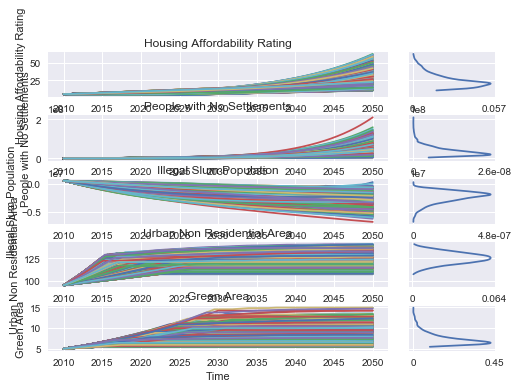

In [23]:
figure = lines(results,density=u'kde') #show lines, and end state density
plt.rcParams["figure.figsize"] = (30,45)
plt.show() #show figure

In [2]:
# Load results (these can be generated with RunExperiments.ipynb if necessary)
results = load_results('./BaseCase_LHS_3000.tar.gz')

[MainProcess/INFO] results loaded succesfully from E:\Study\Delft\Papers\V2\BaseCase_LHS_3000.tar.gz


In [3]:
outputs = list(results[1].keys())[1:] 

for x in outputs:
    fig = lines(results, outcomes_to_show=[x], density=KDE)
plt.show()

MemoryError: 

In [3]:
experiments, outcomes = results

In [16]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyHAfford(data):
    ooi = 'Housing Affordability Rating'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>10] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyHAfford, threshold=0.8)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 3000 points remaining, containing 1963 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.5386666666666666, coverage: 0.8232297503820682, density: 1.0 restricted_dimensions: 1


In [17]:
box_1.show_tradeoff()
mpld3.display()

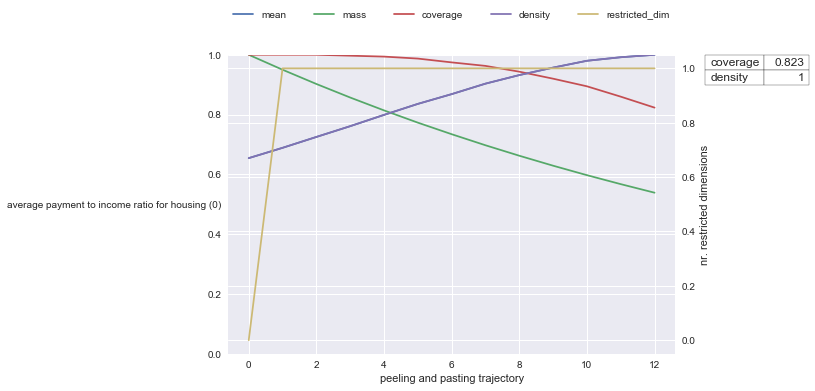

In [18]:
box_1.show_ppt()
plt.show()

coverage     0.82323
density            1
mass        0.538667
mean               1
res dim            1
Name: 12, dtype: object

                                               box 12                    
                                                  min       max qp values
average payment to income ratio for housing  0.338404  0.499981       0.0



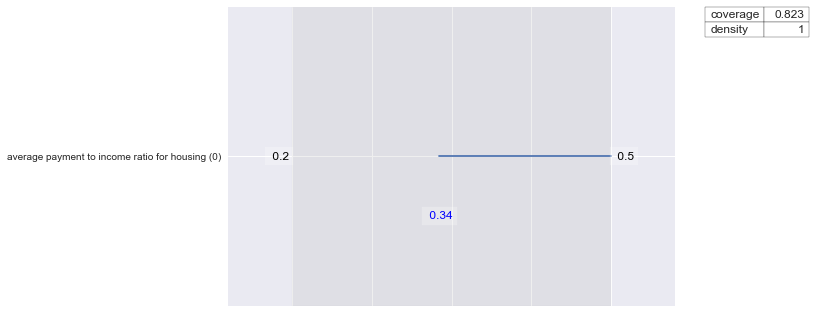

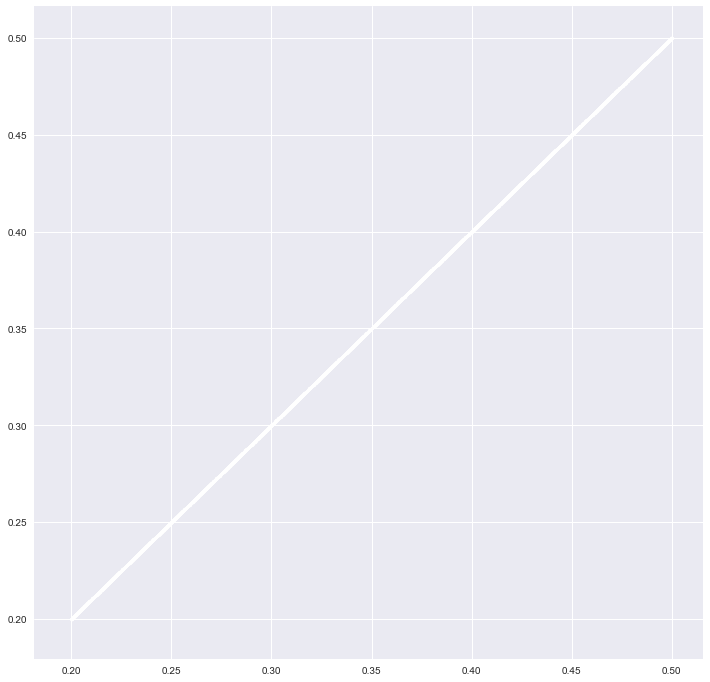

In [22]:
valuebox = 12
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [56]:
ema_logging.log_to_stderr(ema_logging.INFO)

#10 is chosen as threshold since it indicates the point above which houses are deemed severely unaffordable (literature-based).

def classifyNoSettle(data):
    ooi = 'People with No Settlements'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>5000000] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyNoSettle, threshold=0.75)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 3000 points remaining, containing 2472 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.37533333333333335, coverage: 0.45550161812297735, density: 1.0 restricted_dimensions: 4


In [57]:
box_1.show_tradeoff()
mpld3.display()

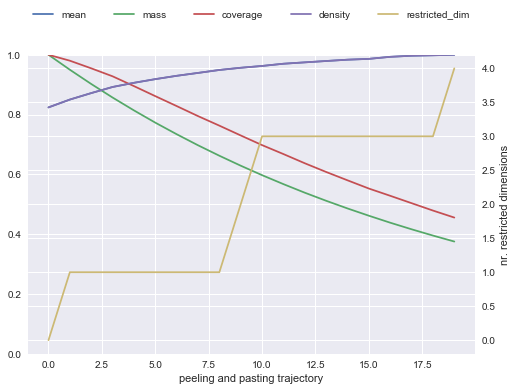

In [31]:
box_1.show_ppt()
plt.show()

coverage    0.697816
density     0.962612
mass        0.597333
mean        0.962612
res dim            3
Name: 10, dtype: object

                                               box 10                        
                                                  min       max     qp values
Base Slum reconversion rate                  0.026891  0.059987  9.896650e-60
average payment to income ratio for housing  0.215995  0.499981  7.853970e-02
average Emmigration percent                  0.009828  0.049994  1.130196e-01



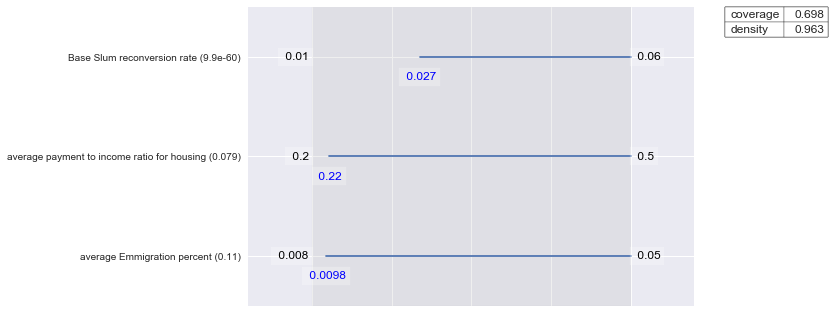

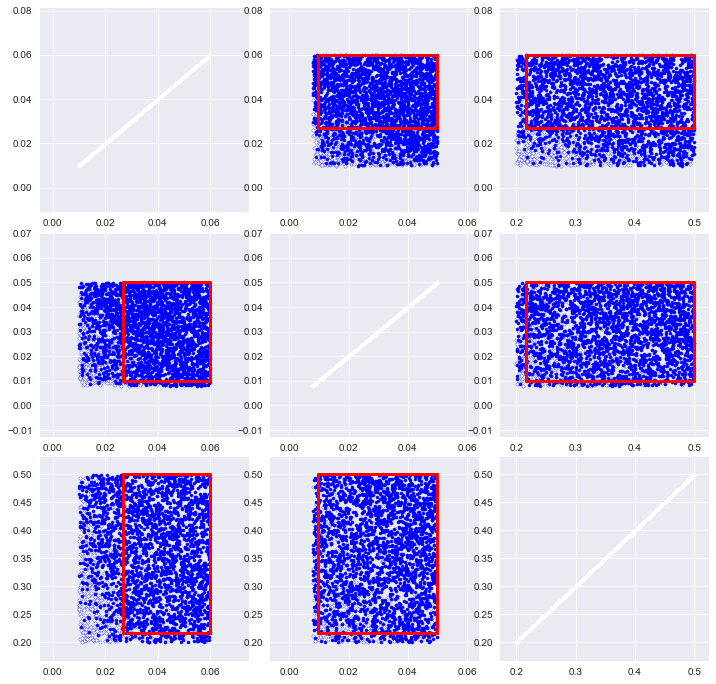

In [58]:
valuebox = 10
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

coverage    0.697816
density     0.962612
mass        0.597333
mean        0.962612
res dim            3
Name: 10, dtype: object

                                               box 10                        
                                                  min       max     qp values
Base Slum reconversion rate                  0.026891  0.059987  9.896650e-60
average payment to income ratio for housing  0.215995  0.499981  7.853970e-02
average Emmigration percent                  0.009828  0.049994  1.130196e-01



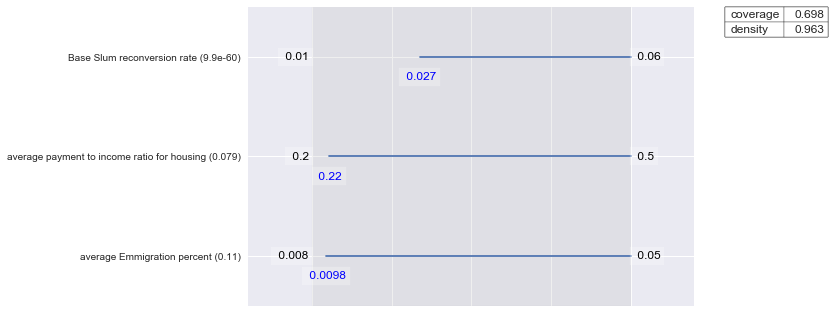

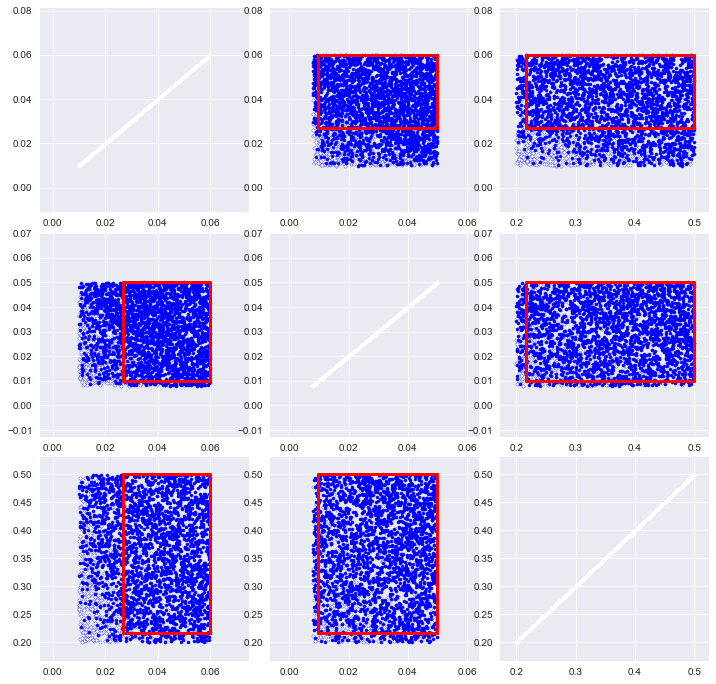

In [33]:
valuebox = 10
box_1.inspect(valuebox)
box_1.select(valuebox)

top_box = valuebox
box_1.inspect(top_box, style='graph')

fig = box_1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [63]:
def classifyBoth(data):
    ooi_d = 'People with No Settlements'
    result_d = data[ooi_d]
    
    ooi_i = 'Illegal Slum Population'
    result_i = np.max(data[ooi_i], axis=1)
    
    #make an empty array of length equal to number of cases 
    classes = np.zeros(result_d.shape[0])
    
    #combine infectious and deceased checks
    classes[(result_d[:, -1] > 9000000) 
            & (result_i > 100000)] = 1
    
    return classes

combo_prim = prim.setup_prim(results, classifyBoth,  
                           threshold=0.8, threshold_type=1)
box1 = combo_prim.find_box()

[MainProcess/INFO] 3000 points remaining, containing 2934 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.6623333333333333, coverage: 0.6772324471710974, density: 1.0 restricted_dimensions: 3


In [64]:
box1.show_tradeoff()
mpld3.display()

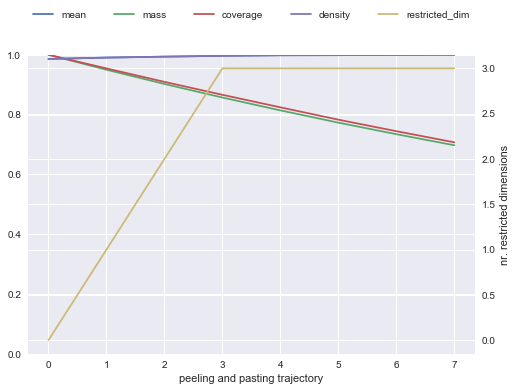

In [50]:
box1.show_ppt()
plt.show()

coverage    0.866126
density     0.996499
mass           0.857
mean        0.996499
res dim            3
Name: 3, dtype: object

                                box 3                    
                                  min       max qp values
Base Slum reconversion rate  0.012500  0.059987  0.005141
average Immigration percent  0.012430  0.059994  0.039838
average Emmigration percent  0.010068  0.049994  0.039957



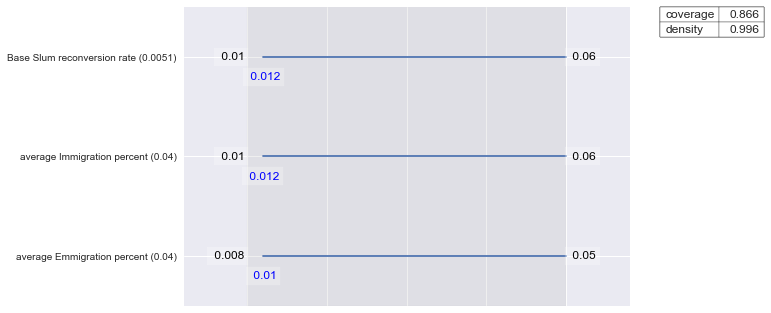

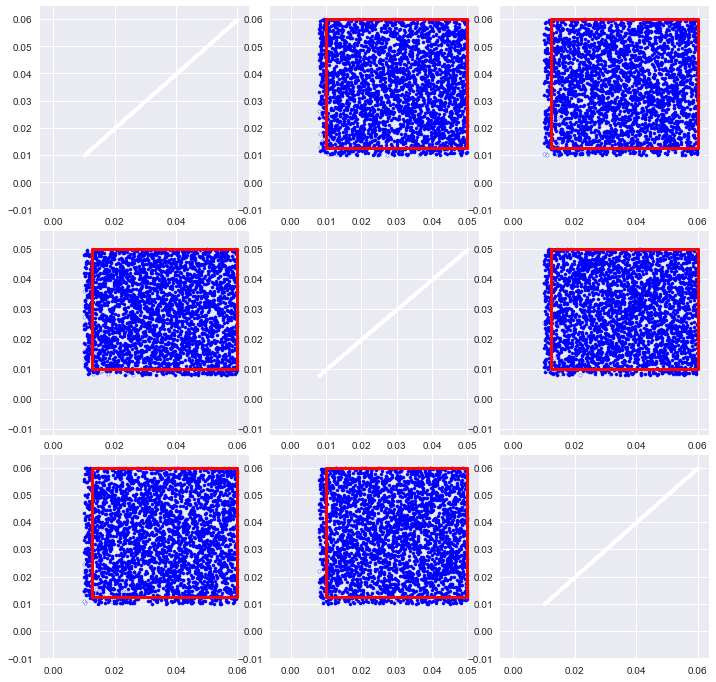

In [51]:
valuebox = 3
box1.inspect(valuebox)
box1.select(valuebox)

top_box = valuebox
box1.inspect(top_box, style='graph')

fig = box1.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [59]:
def classifyUrbanNon(data):
    ooi = 'Urban Non Residential Area'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<120] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyUrbanNon, threshold=0.75)
box_2 = prim_obj.find_box()

[MainProcess/INFO] 3000 points remaining, containing 1273 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.15466666666666667, coverage: 0.3644933228593873, density: 1.0 restricted_dimensions: 3


In [60]:
box_2.show_tradeoff()
mpld3.display()

coverage    0.750982
density     0.806071
mass        0.395333
mean        0.806071
res dim            2
Name: 18, dtype: object

                                       box 18                         
                                          min       max      qp values
Base Economic area Conversion rate   0.010009  0.030814  1.805523e-151
Average Residential approval period  0.573266  1.999871   1.071207e-01



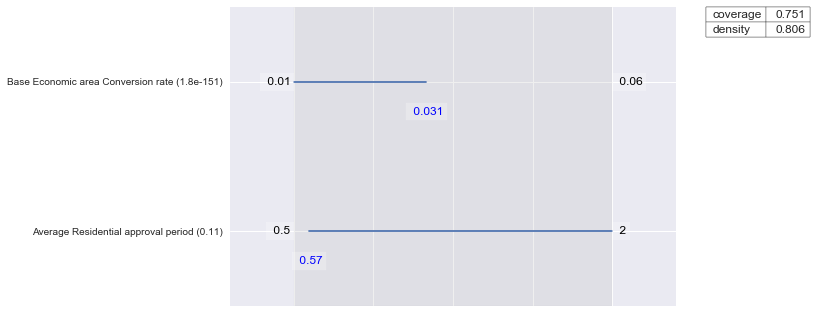

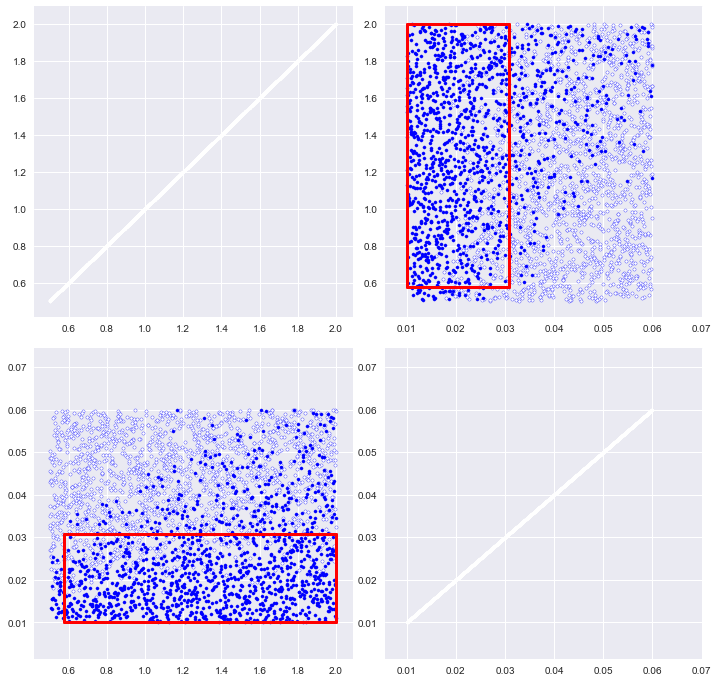

In [61]:
valuebox = 18
box_2.inspect(valuebox)
box_2.select(valuebox)

top_box = valuebox
box_2.inspect(top_box, style='graph')

fig = box_2.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()

In [9]:
def classifyGreenA(data):
    ooi = 'Green Area'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome<8] = 1
    return classes


prim_obj = prim.setup_prim(results, classifyGreenA, threshold=0.8)
box_3 = prim_obj.find_box()

[MainProcess/INFO] 3000 points remaining, containing 2604 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.486, coverage: 0.5599078341013825, density: 1.0 restricted_dimensions: 2


In [10]:
box_3.show_tradeoff()
mpld3.display()

coverage    0.789939
density      0.98327
mass        0.697333
mean         0.98327
res dim            2
Name: 7, dtype: object

                                         box 7                        
                                           min       max     qp values
Base Economic area Conversion rate    0.023277  0.059987  6.005894e-69
Base Green Area commisioned per year  0.020007  0.057957  9.742786e-03



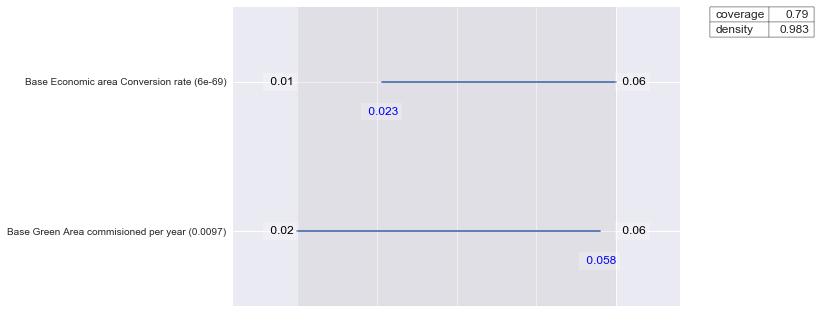

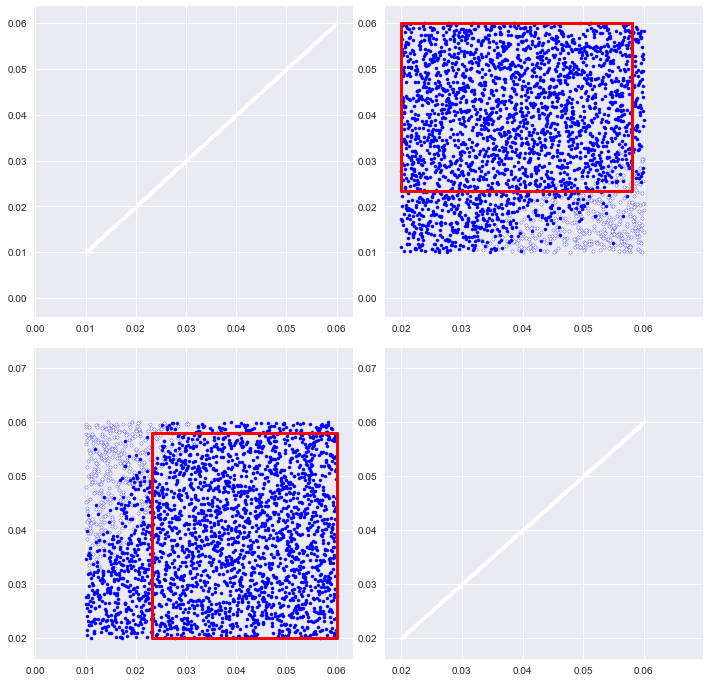

In [11]:
valuebox = 7
box_3.inspect(valuebox)
box_3.select(valuebox)

top_box = valuebox
box_3.inspect(top_box, style='graph')

fig = box_3.show_pairs_scatter()
fig.set_size_inches((12,12))
plt.show()
plt.close()